Install packages

Add ifind

In [1]:
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-17-openjdk-amd64/'
os.environ['JVM_PATH'] = os.environ['JAVA_HOME'] + 'lib/server/libjvm.so'

In [2]:
!export PYTHONPATH="${PYTHONPATH}:./ifind"b

Prepare topics

Run simulations

In [13]:
!cd workspace/simiir/ && python run_simiir.py ../sims/wapo_simulation.xml

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.
SIMULATION 'wtr_sim-1-fixeddepthuser10'
  Simulation Configuration:
    Topic: 1
    Search Interface: PyterrierWebSearchInterface
        index_dir: 

  User Configuration (fixeddepthuser10):
    Query Generator: PredeterminedQueryGenerator
        stopword_file: ../example_data/terms/stopwords.txt
        query_file: /workspace/data/wapo/title_queries_naive_100
        user: 1
    Snippet Classifier: StochasticInformedTrecTextClassifier
        qrel_file: /workspace/data/wapo/wapo_qrels
        rprob: 1.0
        nprob: 0.0
        data_handler: 0
    Document Classifier: StochasticInformedTrecTextClassifier
        qrel_file: /workspace/data/wapo/wapo_qrels
        rprob: 1.0
        nprob: 0.0
        data_handler: 0
    Stopping Decision Maker: FixedDepthDecisionMaker
        depth: 10
    SE

In [9]:
import requests 
import json 

def fetch_and_parse(url):
        try:
            response = requests.get(url)
            response.raise_for_status()
        except requests.exceptions.HTTPError as errh:
            print ("Http Error:", errh)
            return
        except requests.exceptions.ConnectionError as errc:
            print ("Error Connecting:", errc)
            return
        except requests.exceptions.Timeout as errt:
            print ("Timeout Error:", errt)
            return
        except requests.exceptions.RequestException as err:
            print ("Something went wrong", err)
            return
        try:
            data = json.loads(response.text)
            return data
        except json.JSONDecodeError as e:
            print("Failed to decode:", e)
            return

import pandas as pd        
url = 'http://localhost:5000/results/' + 'ipod models'
pd.DataFrame.from_dict(fetch_and_parse(url).get('response'))

,docid,docno,qid,query,rank,score
0,186727,25/1438042987155.85_20150728002307-00340-ip-10...,1,ipod models,0,32.937807
1,440541,8/1438042986022.41_20150728002306-00173-ip-10-...,1,ipod models,1,32.937807
2,450132,9/1438042990611.52_20150728002310-00287-ip-10-...,1,ipod models,2,32.937807
3,1135155,49/1438042988962.66_20150728002308-00153-ip-10...,1,ipod models,3,32.937807
4,1682637,21/1438042988840.31_20150728002308-00289-ip-10...,1,ipod models,4,32.937807
...,...,...,...,...,...,...
95,652224,36/1438042988598.68_20150728002308-00103-ip-10...,1,ipod models,95,20.019445
96,733658,47/1438042986444.39_20150728002306-00036-ip-10...,1,ipod models,96,20.010496
97,2294055,2/1438042981856.5_20150728002301-00059-ip-10-2...,1,ipod models,97,20.010496
98,101662,13/1438042992543.60_20150728002312-00271-ip-10...,1,ipod models,98,19.992620


# Evaluations

## Modalities

### sDCG 

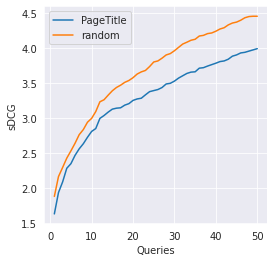

In [55]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')


def dcg(results, topic):
    _dcg = 0
    for i,result in enumerate(results):
        _doc = qrels.get((str(topic),result))
        
        if _doc is not None:
            _dcg += int(_doc) / (1 + math.log(i+1, b))

    return _dcg

b = 2
bq = 4

qrels_path = 'wtr/queries_qrels/rel_table_qrels.txt'
qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

modality_eval = {}
sdcg_eval = {}

# TODO: update/extend modalities
modalities = ['PageTitle', 'random']
depth = 10
query_type = 'gpt'


for modality in modalities:
    
    if modality == 'random':
        probabilities = 'rprob05nprob05'
    else:
        probabilities = 'rprob10nprob00'
        
    for topic in range(1, 61):
        
        log_path = "sims/output/wtr_sim-" + str(topic) + "-fixeddepthuser" + str(depth) + "-" + modality + "-" + query_type + "-" + probabilities + ".log"
        
        query_logs = {}
                    
        query = ''
        results = []
                        
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')

                if logs[1] == 'QUERY':
                    if len(query) > 0:
                        query_logs[query] = results
                    results = []
                    query = ' '.join(logs[4:]).strip('\n')
                    
                if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                    results.append(logs[-1].replace("b'", "").replace("'", "").strip('\n'))      

        sdcg = {}
        _sdcg = 0.0

        for q, query in enumerate(query_logs.keys()):
            results = query_logs.get(query)    
            _sdcg += dcg(results, topic) / (1 + math.log(q + 1, bq))
            sdcg[q+1] = _sdcg
            
        sdcg_eval[topic] = sdcg
    modality_eval[modality] = pd.DataFrame.from_dict(sdcg_eval)[:50].T.mean().to_dict()
    
pd.DataFrame.from_dict(modality_eval).plot(xlabel='Queries', ylabel='sDCG', figsize=(4,4))
plt.savefig('figures/sdcg.modality.pdf', bbox_inches="tight")
plt.show()

### Effort vs. Effect

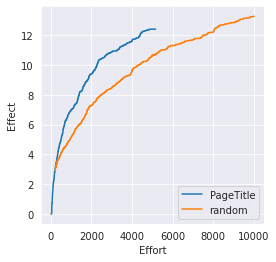

In [54]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')


qrels_path = 'wtr/queries_qrels/rel_table_qrels.txt'
qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

modality_eval = {}
gain_all = {}

# TODO: update/extend modalities
modalities = ['PageTitle', 'random']

depth = 10
query_type = 'gpt'

for modality in modalities:
    
    if modality == 'random':
        probabilities = 'rprob05nprob05'
    else:
        probabilities = 'rprob10nprob00'

    for topic in range(1,61):
        
        log_path = "sims/output/wtr_sim-" + str(topic) + "-fixeddepthuser" + str(depth) + "-" + modality + "-" + query_type + "-" + probabilities + ".log"
        
        query_logs = {}
                    
        query = ''
        results = []
        
        _gain = 0
        gain = {}                
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')
                
                if len(logs) > 4 and logs[0] == 'ACTION':

                    if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                        result = logs[-1].replace("b'", "").replace("'", "").strip('\n')
                        if qrels.get((str(topic),result)):
                            _gain += int(qrels.get((str(topic),result)))
                    gain[int(logs[3])] = _gain
        gain_all[topic] = gain
    modality_eval[modality] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
pd.DataFrame.from_dict(modality_eval).plot(xlabel='Effort', ylabel='Effect', figsize=(4,4))
plt.savefig('figures/effort.effect.modality.pdf', bbox_inches="tight")
plt.show()

## Depth evaluation

### sDCG

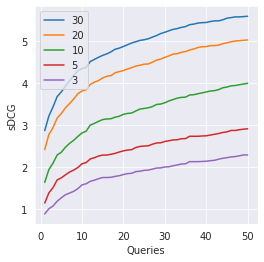

In [67]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')


def dcg(results, topic):
    _dcg = 0
    for i,result in enumerate(results):
        _doc = qrels.get((str(topic),result))
        
        if _doc is not None:
            _dcg += int(_doc) / (1 + math.log(i+1, b))

    return _dcg

b = 2
bq = 4

qrels_path = 'wtr/queries_qrels/rel_table_qrels.txt'
qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

depth_eval = {}
sdcg_eval = {}

depths = [30, 20, 10, 5, 3]
modality = 'PageTitle'
query_type = 'gpt'
probabilities = 'rprob10nprob00'

for depth in depths:

    for topic in range(1, 61):
        
        log_path = "sims/output/wtr_sim-" + str(topic) + "-fixeddepthuser" + str(depth) + '-' + modality + "-" + query_type + "-" + probabilities + ".log"
        
        query_logs = {}
                    
        query = ''
        results = []
                        
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')

                if logs[1] == 'QUERY':
                    if len(query) > 0:
                        query_logs[query] = results
                    results = []
                    query = ' '.join(logs[4:]).strip('\n')
                    
                if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                    results.append(logs[-1].replace("b'", "").replace("'", "").strip('\n'))      

        sdcg = {}
        _sdcg = 0.0

        for q, query in enumerate(query_logs.keys()):
            results = query_logs.get(query)    
            _sdcg += dcg(results, topic) / (1 + math.log(q + 1, bq))
            sdcg[q+1] = _sdcg
            
        sdcg_eval[topic] = sdcg
    depth_eval[depth] = pd.DataFrame.from_dict(sdcg_eval)[:50].T.mean().to_dict()
    
pd.DataFrame.from_dict(depth_eval).plot(xlabel='Queries', ylabel='sDCG', figsize=(4,4))
plt.savefig('figures/sdcg.depth.pdf', bbox_inches="tight")
plt.show()

### Effort vs. Effect

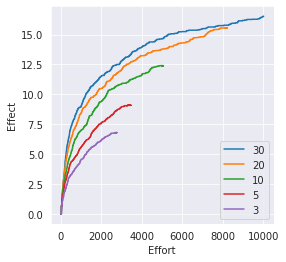

In [66]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')


qrels_path = 'wtr/queries_qrels/rel_table_qrels.txt'
qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

depth_eval = {}
gain_all = {}

depths = [30, 20, 10, 5, 3]
modality = 'PageTitle'
query_type = 'gpt'
probabilities = 'rprob10nprob00'


for depth in depths:

    for topic in range(1,61):
        
        log_path = "sims/output/wtr_sim-" + str(topic) + "-fixeddepthuser" + str(depth) + '-' + modality + "-" + query_type + "-" + probabilities + ".log"
        query_logs = {}
                    
        query = ''
        results = []
        
        _gain = 0
        gain = {}                
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')
                
                if len(logs) > 4 and logs[0] == 'ACTION':

                    if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                        result = logs[-1].replace("b'", "").replace("'", "").strip('\n')
                        if qrels.get((str(topic),result)):
                            _gain += int(qrels.get((str(topic),result)))
                    gain[int(logs[3])] = _gain
        gain_all[topic] = gain
    depth_eval[depth] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
pd.DataFrame.from_dict(depth_eval).plot(xlabel='Effort', ylabel='Effect', figsize=(4,4))
plt.savefig('figures/effort.effect.depth.pdf', bbox_inches="tight")
plt.show()

## Browsing behavior

### sDCG

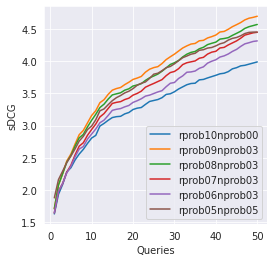

In [65]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')


def dcg(results, topic):
    _dcg = 0
    for i,result in enumerate(results):
        _doc = qrels.get((str(topic),result))
        
        if _doc is not None:
            _dcg += int(_doc) / (1 + math.log(i+1, b))

    return _dcg

b = 2
bq = 4

qrels_path = 'wtr/queries_qrels/rel_table_qrels.txt'
qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

prob_eval = {}
sdcg_eval = {}

depth = 10
query_type = 'gpt'
probabilities = ['rprob10nprob00','rprob09nprob03', 'rprob08nprob03', 'rprob07nprob03', 'rprob06nprob03', 'rprob05nprob05']

for probability in probabilities:

    if probability == 'rprob05nprob05':
        modality = 'random' 
    else:
        modality = 'PageTitle'

    for topic in range(1, 61):
        
        log_path = "sims/output/wtr_sim-" + str(topic) + "-fixeddepthuser" + str(depth) + '-' + modality + "-" + query_type + "-" + probability + ".log"
        
        query_logs = {}
                    
        query = ''
        results = []
                        
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')

                if logs[1] == 'QUERY':
                    if len(query) > 0:
                        query_logs[query] = results
                    results = []
                    query = ' '.join(logs[4:]).strip('\n')
                    
                if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                    results.append(logs[-1].replace("b'", "").replace("'", "").strip('\n'))      

        sdcg = {}
        _sdcg = 0.0

        for q, query in enumerate(query_logs.keys()):
            results = query_logs.get(query)    
            _sdcg += dcg(results, topic) / (1 + math.log(q + 1, bq))
            sdcg[q+1] = _sdcg
            
        sdcg_eval[topic] = sdcg
    prob_eval[probability] = pd.DataFrame.from_dict(sdcg_eval)[:50].T.mean().to_dict()
    
pd.DataFrame.from_dict(prob_eval).plot(xlabel='Queries', ylabel='sDCG', figsize=(4,4))
plt.savefig('figures/sdcg.browse.pdf', bbox_inches="tight")
plt.show()

### Effort vs. Effect

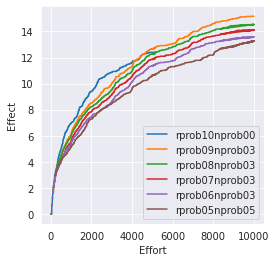

In [68]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')

qrels_path = 'wtr/queries_qrels/rel_table_qrels.txt'
qrels = {}
with open(qrels_path) as f_in:
    for line in f_in.readlines():
        parts = line.split(' ')
        qrels[(parts[0],parts[2])] = parts[3]

prob_eval = {}
gain_all = {}

depth = 10
query_type = 'gpt'
probabilities = ['rprob10nprob00','rprob09nprob03', 'rprob08nprob03', 'rprob07nprob03', 'rprob06nprob03', 'rprob05nprob05']

for probability in probabilities:

    if probability == 'rprob05nprob05':
        modality = 'random' 
    else:
        modality = 'PageTitle'

    for topic in range(1,61):
        
        log_path = "sims/output/wtr_sim-" + str(topic) + "-fixeddepthuser" + str(depth) + '-' + modality + "-" + query_type + "-" + probability + ".log"
        
        query_logs = {}
                    
        query = ''
        results = []
        
        _gain = 0
        gain = {}                
        with open(log_path) as f_in:

            for line in f_in.readlines():
                logs = line.split(' ')
                
                if len(logs) > 4 and logs[0] == 'ACTION':

                    if logs[1] == 'MARK' and logs[4] == 'CONSIDERED_RELEVANT':
                        result = logs[-1].replace("b'", "").replace("'", "").strip('\n')
                        if qrels.get((str(topic),result)):
                            _gain += int(qrels.get((str(topic),result)))
                    gain[int(logs[3])] = _gain
        gain_all[topic] = gain
    prob_eval[probability] = pd.DataFrame.from_dict(gain_all).sort_index().fillna(method='ffill').T.mean().to_dict()
pd.DataFrame.from_dict(prob_eval).plot(xlabel='Effort', ylabel='Effect', figsize=(4,4))
plt.savefig('figures/effort.effect.browse.pdf', bbox_inches="tight")
plt.show()